In [76]:
#Import bibliotek
import pandas as pd
import csv as csv
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import scipy
import sklearn as sk
import Analysis
import math as mt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
sns.set_theme(style="darkgrid")

In [77]:
#Zmienne konfiguracyjne
path_s_d = "C:\\Users\\Robin\\Jupyter Notebooks\\Dane\\Dane zebrane - Warszawa\\Warszawa.csv"
Miesiace_names = ['styczen','luty','marzec','kwiecien','maj','czerwiec','lipiec','sierpien','wrzesien','pazdziernik','listopad','grudzien']

In [78]:
#Wczytanie plików .csv pandasem
df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])
df['Pora roku'] = 0
df.loc[(df['Miesiac']<3) |(df['Miesiac']==12),'Pora roku']=4
df.loc[(2<df['Miesiac']) & (df['Miesiac']<6),'Pora roku']=1
df.loc[(5<df['Miesiac']) & (df['Miesiac']<9),'Pora roku']=2
df.loc[(8<df['Miesiac']) & (df['Miesiac']<12),'Pora roku']=3
df['Wystapienie burzy_'] = 0
df.loc[df['Czas trwania burzy  [godziny]']>0,'Wystapienie burzy_'] = 1
Lata = df['Rok'].drop_duplicates().copy().to_frame()
Lata.reset_index(inplace=True)
Lata.drop(columns='index',inplace=True)
Miesiace = df['Miesiac'].drop_duplicates().copy().to_frame()
Miesiace.reset_index(inplace=True)
Miesiace.drop(columns='index',inplace=True)

Ulewa = df.copy()
Ulewa['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Ulewa.size / Ulewa.columns.size)):
    Temp[x] = Ulewa.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Ulewa.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Ulewa['dP'] = Temp
df['dP'] = Temp

#df[]
Ulewa = Ulewa.loc[(Ulewa['Rodzaj opadu [S/W/ ]'] == 'W') & (Ulewa['Status pomiaru SMDB'] != '8')]
Ulewa = Ulewa.loc[(Ulewa['Status pomiaru PPPS'] != '8') & (Ulewa['Status pomiaru WLGS'] != '8')]
Ulewa = Ulewa.loc[(Ulewa['Status pomiaru STD'] != '8')]

In [237]:
#Funkcje klasyfikujące
def timeseries_train_test_split(X, y, test_size):
    """Perform train-test split with respect to time series structure."""
    test_index = int(len(X) * (1 - test_size))
    X_train = X[:test_index]
    X_test = X[test_index:]
    y_train = y[:test_index]
    y_test = y[test_index:]
    return X_train, X_test, y_train, y_test


def mean_absolute_percentage_error(y_true, y_pred):
    #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return np.mean(np.abs(y_true-y_pred))


def plot_model_results(X, y, test_size=0.3, plot_intervals=False, plot_anomalies=False):
    """
    - Plots modelled vs original values.
    - Prediction intervals (95% confidence interval).
    - Anomalies (points that resides outside the confidence interval).
    """

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size)

    # we are using random forest here, feel free to swap this out
    # with your favorite regression model
    #model = sk.ensemble.AdaBoost()Classifier
    #model = sk.ensemble.ExtraTrees()
    #model = RandomForestRegressor(max_depth=6, n_estimators=50)
    #model = sk.ensemble.BaggingRegressor()

    model = sk.ensemble.ExtraTreesClassifier()
    model2 = sk.ensemble.AdaBoostClassifier()
    model3 = sk.ensemble.ExtraTreesClassifier(max_depth=6,n_estimators=50 ,max_features="sqrt")
    model4 = sk.ensemble.RandomForestClassifier()#(max_depth=6, n_estimators=50)
    model5 = sk.ensemble.BaggingClassifier()
    kekw = ('Extra','Ada','Extra_limied','Random','Bagging')
    models = (model, model2, model3, model4, model5)
    z=0
    for k in models:
        fig,_ = plt.subplots(nrows=1,figsize=(5,5))
        ax = plt.subplot(1,1,1)
        ax.grid(False)
        k.fit(X_train, y_train)
        prediction = k.predict(X_test)
        conf_mat = sk.metrics.confusion_matrix(y_test,prediction)
        print(kekw[z])
        print(conf_mat)
        precision, recall,_,support = sk.metrics.precision_recall_fscore_support(y_test,prediction)
        print("Precision: ",precision, "Recall: ",recall,"Support: ", support)
        disp = sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test,prediction,ax=ax)
        z+=1
    
    plt.figure(figsize=(15, 7))
    x = range(prediction.size)
    plt.plot(x, y_test, label='actual', linewidth=2.0)
    plt.plot(x, prediction, label='prediction', linewidth=1.0)
    
    if plot_intervals:
        timeseries_cv = TimeSeriesSplit(n_splits=5)
        cv = cross_val_score(model, X_train, y_train, 
                             cv=timeseries_cv, scoring='neg_mean_absolute_error')
        mae = -1 * cv.mean()
        deviation = cv.std()

        # dla 95% sprawności trzeba zastosować
        # 1.959 dewiacji
        scale = 1.96
        margin_error = mae + scale * deviation
        lower = prediction - margin_error
        upper = prediction + margin_error

        fill_alpha = 0.2
        fill_color = '#66C2D7'
        plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')      

        if plot_anomalies:
            anomalies = np.array([np.nan] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, 'o', markersize=10, label='Anomalies')

    error = mean_absolute_percentage_error(prediction, y_test)
    #plt.title('Mean absolute percentage error {0:.2f}%'.format(error))
    plt.title('Mean absolute error {0:.4f}'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    
    return model

In [151]:
#Funkcje
def Ilosc_Wystapien_lata(Zjawisko_df:pd.DataFrame, Lata_df:pd.DataFrame):
    temp = Zjawisko_df['Rok'].value_counts().to_frame().copy()
    temp.sort_index(inplace=True)
    temp.reset_index(inplace=True)
    temp.columns = ['Rok','Ilosc']
    Wystapienia = Lata_df.copy()
    Wystapienia['Ilosc'] = 0
    for x in range(temp.shape[0]):
        Wystapienia.loc[Wystapienia['Rok']==temp.iloc[x].loc['Rok'],['Ilosc']] += temp.iloc[x].loc['Ilosc']
    return Wystapienia

def Ilosc_Wystapien_miesiace(Zjawisko_df:pd.DataFrame, Miesiace_df:pd.DataFrame):
    temp = Zjawisko_df['Miesiac'].value_counts().to_frame().copy()
    temp.sort_index(inplace=True)
    temp.reset_index(inplace=True)
    temp.columns = ['Miesiac','Ilosc']
    Wystapienia = Miesiace_df.copy()
    Wystapienia['Ilosc'] = 0
    for x in range(temp.shape[0]):
        Wystapienia.loc[Wystapienia['Miesiac']==temp.iloc[x].loc['Miesiac'],['Ilosc']] += temp.iloc[x].loc['Ilosc']
    return Wystapienia

def Korelacja_okno(data1, data2, szerokosc_korelacji = 30, koniec = 0, start = 0):
    if koniec == 0:
        koniec = data1.shape[0]-szerokosc_korelacji
    korSpC = []
    korSpP = []
    korPrC = []
    korPrP = []
    Dziedzina = []
    for x in range(start, koniec):
        y = x+szerokosc_korelacji

        Dziedzina.append(x % (koniec-start))
        coef, p = scipy.stats.spearmanr(data1[x:y], data2[x:y])
        korSpC.append(coef)
        korSpP.append(p)
        coef, p = scipy.stats.pearsonr(data1[x:y], data2[x:y])
        korPrC.append(coef)
        korPrP.append(p)

    #fig, ax = plt.subplots()
    #ax.set_title('Korelacja')
    #ax.set_xlabel('Czas')
    #ax.set_ylabel('Korelacja Spearmana')
    tempplt = plt.plot(Dziedzina,korSpC);  # Plot some data on the axes.
   
    #fig, ax = plt.subplots()
    #plt.plot(Dziedzina,korPrC);  # Plot some data on the axes.
    #ax.set_title('Korelacja')
    #ax.set_xlabel('Czas')
    #ax.set_ylabel('Korelacja Pearsona')
    #plt.show()
    return tempplt

def Korelacja_okno_wilg(data1, data2, szerokosc_korelacji = 30, koniec = 0, start = 0):
    if koniec == 0:
        koniec = data1.shape[0]-szerokosc_korelacji
    korSpC = []
    korSpP = []
    korPrC = []
    korPrP = []
    Dziedzina = []
    for x in range(start, koniec):
        y = x+szerokosc_korelacji
        Dziedzina.append(data1.iloc[x])
        coef, p = scipy.stats.spearmanr(data1[x:y], data2[x:y])
        korSpC.append(coef)
        korSpP.append(p)
        coef, p = scipy.stats.pearsonr(data1[x:y], data2[x:y])
        korPrC.append(coef)
        korPrP.append(p)

    #fig, ax = plt.subplots()
    #ax.set_title('Korelacja')
    #ax.set_xlabel('Czas')
    #ax.set_ylabel('Korelacja Spearmana')
    #tempplt = plt.plot(Dziedzina,korSpC)  # Plot some data on the axes.
    
    tempplt = plt.scatter(Dziedzina,korSpC,s=20)
    
    #fig, ax = plt.subplots()
    #plt.plot(Dziedzina,korPrC);  # Plot some data on the axes.
    #ax.set_title('Korelacja')
    #ax.set_xlabel('Czas')
    #ax.set_ylabel('Korelacja Pearsona')
    #plt.show()
    return tempplt

def Rolling_window(data:pd.DataFrame, colummtuple:tuple, Values:str, window_size:int = 5):
    new_data=pd.DataFrame()
    new_data['Pora roku'] = data['Pora roku']
    for i in colummtuple:
        for j in range(1, window_size):
            new_data['lag_{}_{}'.format(i,j)] = data[i].shift(j)
    
    # for i in range(1, window_size):
    #     new_data['lag_c1_{}'.format(i)] = data[column1].shift(i)
        
    #     #generowanie średnich
    #     #lag_cols = [col for col in new_data.columns if 'lag_c1' in col]
    #     #new_data['rolling_mean_c1'] = new_data[lag_cols].mean(axis=1)
    #     #lag_cols = [col for col in new_data.columns if 'lag_c2' in col]
    #     #new_data['rolling_mean_c2'] = new_data[lag_cols].mean(axis=1)
    #     #print(lag_cols)
    #     #new_data['rolling_mean_c1_1'] = new_data[column1].shift(0).rolling(window=window_size).mean().dropna()
    #     #new_data['rolling_mean_c2_1'] = new_data[column2].shift(0).rolling(window=window_size).mean().dropna()
    #     #print(new_data[['rolling_mean_c1','rolling_mean_c2','rolling_mean_c1_1','rolling_mean_c2_1']])
    #     new_data['lag_c2_{}'.format(i)] = data[column2].shift(i)
    
    #extract out the features and labels into separate variables
        #y = data[label_col].values
        #data = data.drop(label_col, axis=1)
        #X = data.values
        #feature_names = data.columns
        #print('dimension: ', X.shape)
        #data.head()
    x = new_data.dropna()
    y = data[Values]
    y = y[window_size-1:]
    return x, y


In [81]:
#Magic number
Ulewa=Ulewa.loc[Ulewa['Suma dobowa opadu [mm]'] > 30]
# Ulewa=Ulewa.loc[Ulewa['Srednie dobowe cisnienie na poziomie stacji [hPa]'] > 1001]
Ulewa.loc[(Ulewa['Czas trwania wiatru >=10m/s [godziny]'] == 0 , 'Kolor')] = 10
Ulewa.loc[(Ulewa['Czas trwania wiatru >=10m/s [godziny]'] > 0 , 'Kolor')] = 128
Ulewa.loc[(Ulewa['Czas trwania wiatru >15m/s [godziny]'] > 0 , 'Kolor')] = 255

c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Robin\AppData\Local\Temp\ipykernel_28844\4149474061.py:70: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([p1,p2,p3], labels=Legenda)


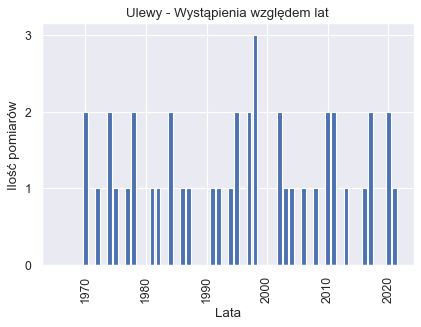

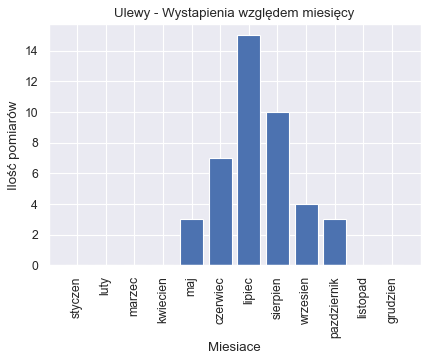

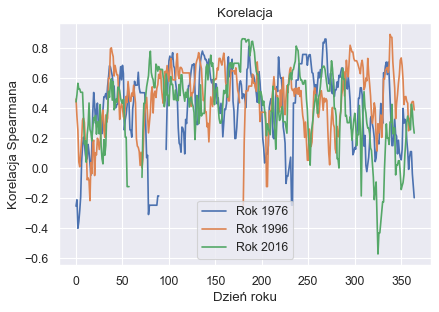

In [117]:
#Ulewa
Ulewa['Zima'] = (Ulewa['Miesiac'] == 12) | (Ulewa['Miesiac'] < 3)
Ulewa['Wiosna'] = (Ulewa['Miesiac'] > 2) & (Ulewa['Miesiac'] < 6)
Ulewa['Lato'] = (Ulewa['Miesiac'] > 5) & (Ulewa['Miesiac'] < 9)
Ulewa['Jesien'] = (Ulewa['Miesiac'] > 8) & (Ulewa['Miesiac'] < 12)
# Ulewa['Ulewa'] = Ulewa['Suma dobowa opadu [mm]']
# Ulewa.loc[Ulewa['Ulewa']>=30,('Ulewa')] = 1
Opady = Ulewa['Suma dobowa opadu [mm]']
Cisnienie = Ulewa['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Srednia_temp = Ulewa['Srednia temperatura dobowa [oC]']
Wilgotnosc = Ulewa['Srednia dobowa wilgotnosc wzgledna [%]']
Kolor = Ulewa['Kolor']

Wystapienia = Ilosc_Wystapien_lata(Ulewa,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Ulewa,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Ulewy - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))


fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Ulewy - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
data1 = df['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = df['Suma dobowa opadu [mm]']

# # Korelacja spearmana
# coef, p = scipy.stats.spearmanr(data1, data2)
# print("Spearman: coef =",coef,"p =",p)

# # Korelacja Pearsona
# coef, p = scipy.stats.pearsonr(data1, data2)
# print("Pearson: coef =",coef,"p =",p)


# # Korelacja kandela
# coef, p = scipy.stats.kendalltau(data1, data2)
# print("Kandel: coef =",coef,"p =",p)

#Generowanie na jednym wykresie, zakomentować opcje wykreślania w funkcji
fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Dzień roku')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
#for n in range(2,3):
#    Korelacja_okno(data1,data2,30,n*365,(n-1)*365)

p1 = Korelacja_okno(data1,data2,15,9*365,(9-1)*365)
p2 = Korelacja_okno(data1,data2,15,29*365,(29-1)*365)
p3 = Korelacja_okno(data1,data2,15,49*365,(49-1)*365)
Legenda = ['Rok 1976','Rok 1996','Rok 2016']
ax.legend([p1,p2,p3], labels=Legenda)
plt.show()


c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


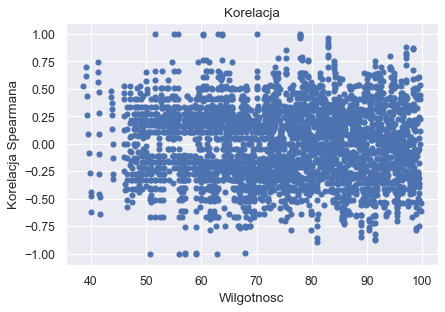

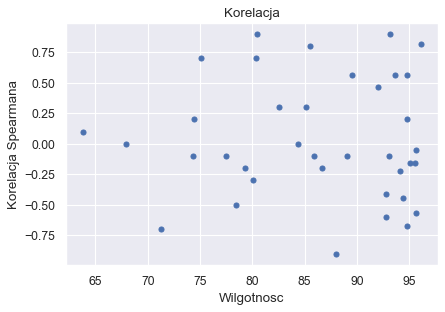

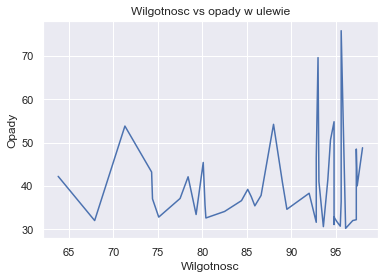

In [126]:
SortedWilgotnosc = df.copy().sort_values('Srednia dobowa wilgotnosc wzgledna [%]')
SortedWilgotnoscUl = Ulewa.copy().sort_values('Srednia dobowa wilgotnosc wzgledna [%]')
#print(SortedWilgotnosc['Srednia dobowa wilgotnosc wzgledna [%]'].tail())
#print(SortedWilgotnoscUl['Srednia dobowa wilgotnosc wzgledna [%]'].tail())

fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
temp=SortedWilgotnosc.loc[(SortedWilgotnosc['Srednia dobowa wilgotnosc wzgledna [%]']>0 ) & (SortedWilgotnosc['Srednia dobowa wilgotnosc wzgledna [%]']<100)]
data1 = temp['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = temp['Suma dobowa opadu [mm]']
p1 = Korelacja_okno_wilg(data1,data2,10,0,0)
plt.show()


fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
data1 = SortedWilgotnoscUl['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = SortedWilgotnoscUl['Suma dobowa opadu [mm]']
p1 = Korelacja_okno_wilg(data1,data2,5,0,0)
plt.show()
fig, ax = plt.subplots()
ax.set_title('Wilgotnosc vs opady w ulewie')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Opady')

plt.plot(data1,data2)
plt.show()

Extra
[[6117    6]
 [  13    0]]
Precision:  [0.99787928 0.        ] Recall:  [0.99902009 0.        ] Support:  [6123   13]
Ada
[[6123    0]
 [  13    0]]
Precision:  [0.99788136 0.        ] Recall:  [1. 0.] Support:  [6123   13]
Extra_limied
[[6123    0]
 [  13    0]]
Precision:  [0.99788136 0.        ] Recall:  [1. 0.] Support:  [6123   13]


c:\Users\Robin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Robin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random
[[6122    1]
 [  13    0]]
Precision:  [0.99788101 0.        ] Recall:  [0.99983668 0.        ] Support:  [6123   13]
Bagging
[[6121    2]
 [  13    0]]
Precision:  [0.99788067 0.        ] Recall:  [0.99967336 0.        ] Support:  [6123   13]


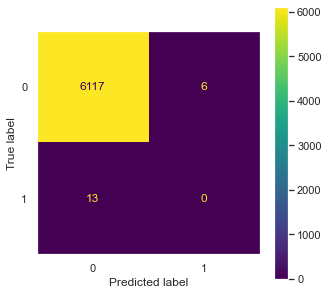

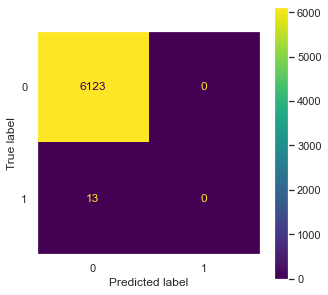

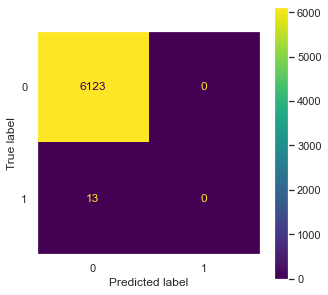

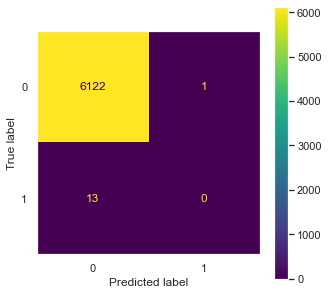

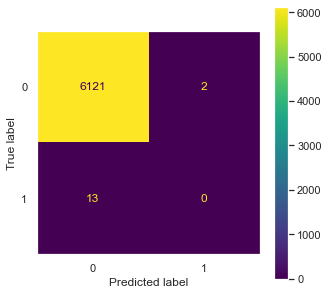

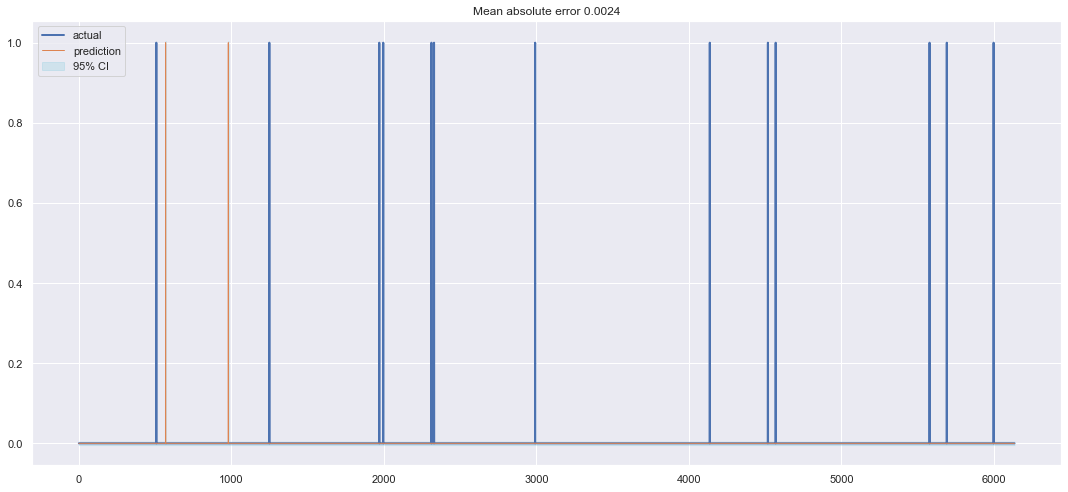

In [245]:
# tututuple = ('Srednie dobowe zachmurzenie ogolne [oktanty]',
# 'Srednia temperatura dobowa [oC]')
# tututuple = ('dP',
# 'Srednie dobowe cisnienie na poziomie stacji [hPa]')
tututuple = ('Srednia dobowa wilgotnosc wzgledna [%]',
'Srednie dobowe zachmurzenie ogolne [oktanty]')
# tututuple = ('Srednie dobowe zachmurzenie ogolne [oktanty]',
# 'Srednia temperatura dobowa [oC]')

BigUlewa = df.copy()
BigUlewa['Ulewa'] = 0
BigUlewa.loc[BigUlewa['Suma dobowa opadu [mm]'] >= 30,'Ulewa'] = 1
x, y = Rolling_window(BigUlewa,tututuple,'Ulewa',2)
model = plot_model_results(x, y, plot_intervals=True)


In [85]:
#Ulewa - korelacja
import math
print("dP - Opady")
Analysis.Korelacja(Ulewa['dP'], K2 = Opady)
print("\nCisnienie - Opady")
Analysis.Korelacja(K1=Cisnienie, K2 = Opady)
print("\nSrednia_temp - Opady")
Analysis.Korelacja(K1 = Srednia_temp, K2 = Opady)
print("\nWilgotnosc - Opady")
Analysis.Korelacja(K1 = Wilgotnosc, K2 = Opady)
print("Ulewa^,V Całość")
print("dP - Opady")
Analysis.Korelacja(df['dP'], K2 = df['Suma dobowa opadu [mm]'])
print("\nCisnienie - Opady")
Analysis.Korelacja(K1=df['Srednie dobowe cisnienie na poziomie stacji [hPa]'], K2 = df['Suma dobowa opadu [mm]'])
print("\nSrednia_temp - Opady")
Analysis.Korelacja(K1 = df['Srednia temperatura dobowa [oC]'], K2 = df['Suma dobowa opadu [mm]'])
print("\nWilgotnosc - Opady")
Analysis.Korelacja(K1 = df['Srednia dobowa wilgotnosc wzgledna [%]'], K2 = df['Suma dobowa opadu [mm]'])

dP - Opady
Korelacja Pearsona: 0.16176836618222415; p = 0.3060709420297663
Korelacja Spearmana: 0.2536375847484931; p = 0.10506462450126135
R^2: 0.16176836618222415 Std_err:0.40046515598213767

Cisnienie - Opady
Korelacja Pearsona: -0.09242401460565504; p = 0.5604669085056218
Korelacja Spearmana: -0.05284701153547125; p = 0.739599041255835
R^2: -0.09242401460565508 Std_err:0.313840169663743

Srednia_temp - Opady
Korelacja Pearsona: 0.14032504846005278; p = 0.37542221369347334
Korelacja Spearmana: 0.1770474532393442; p = 0.26200668655526593
R^2: 0.1403250484600528 Std_err:0.3131423246410271

Wilgotnosc - Opady
Korelacja Pearsona: 0.09537231697584556; p = 0.5479715681234318
Korelacja Spearmana: -0.07044137460736352; p = 0.6575583334160496
R^2: 0.09537231697584556 Std_err:0.17382483763050968
Ulewa^,V Całość
dP - Opady
Korelacja Pearsona: -0.1498233198011028; p = 5.556272249162043e-103
Korelacja Spearmana: -0.20230975705511617; p = 6.995455862061863e-188
R^2: -0.14982331980110022 Std_err:0

In [86]:
#Wczytanie plików .csv pandasem - Snow
#df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])

Snow = df.copy()
Snow['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Snow.size / Snow.columns.size)):
    Temp[x] = Snow.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Snow.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Snow['dP'] = Temp

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Snow.size / Snow.columns.size)):
    Temp[x] = Snow.iloc[x]['Wysokosc pokrywy snieznej [cm]'] - Snow.iloc[x-1]['Wysokosc pokrywy snieznej [cm]']
Snow['dPs'] = Temp

Snow=Snow.loc[Snow['Wysokosc pokrywy snieznej [cm]'] >= 15]
Snow=Snow.loc[Snow['Czas trwania wiatru >=10m/s [godziny]'] >= 1]

#df['Czas trwania wiatru >=10m/s [godziny]']
Snow = Snow.loc[(Snow['Rodzaj opadu [S/W/ ]'] == 'S') & (Snow['Status pomiaru SMDB'] != '8')]
Snow = Snow.loc[(Snow['Status pomiaru PPPS'] != '8') & (Snow['Status pomiaru WLGS'] != '8')]
Snow = Snow.loc[(Snow['Status pomiaru STD'] != '8')]
Snow = Snow.loc[(Snow['Status pomiaru PKSN'] != '8')]
Snow.loc[(Snow['Czas trwania wiatru >=10m/s [godziny]'] == 0 , 'Kolor')] = 10
Snow.loc[(Snow['Czas trwania wiatru >=10m/s [godziny]'] > 0 , 'Kolor')] = 128
Snow.loc[(Snow['Czas trwania wiatru >15m/s [godziny]'] > 0 , 'Kolor')] = 255


c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Robin\AppData\Local\Temp\ipykernel_28844\1930908278.py:54: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([p1,p2,p3], labels=Legenda)


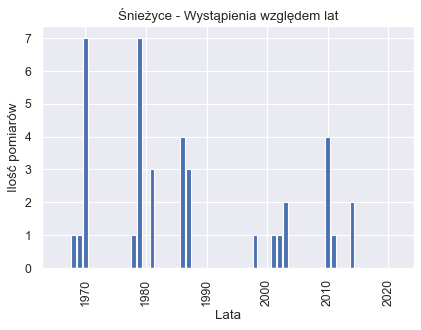

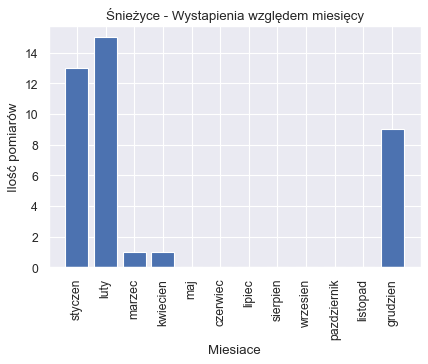

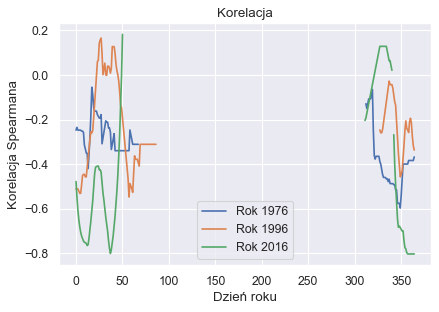

In [186]:
#Snow
Opady_s = Snow['Suma dobowa opadu [mm]']
Cisnienie_s = Snow['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Srednia_temp_s = Snow['Srednia temperatura dobowa [oC]']
Wilgotnosc_s = Snow['Srednia dobowa wilgotnosc wzgledna [%]']
Pokrywa_s = Snow['Wysokosc pokrywy snieznej [cm]']
Kolor = Snow['Kolor']
Wystapienie_sniegu = Snow['Rok']

Wystapienia = Ilosc_Wystapien_lata(Snow,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Snow,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Śnieżyce - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Śnieżyce - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
data1 = df['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = df['Suma dobowa opadu [mm]']

#Generowanie na jednym wykresie, zakomentować opcje wykreślania w funkcji
fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Dzień roku')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)

data1 = df['Wysokosc pokrywy snieznej [cm]']
data2 = df['Srednia temperatura dobowa [oC]']
#for n in range(2,3):
#    Korelacja_okno(data1,data2,30,n*365,(n-1)*365)
p1 = Korelacja_okno(data1,data2,30,9*365,(9-1)*365)
p2 = Korelacja_okno(data1,data2,30,29*365,(29-1)*365)
p3 = Korelacja_okno(data1,data2,30,49*365,(49-1)*365)
Legenda = ['Rok 1976','Rok 1996','Rok 2016']
ax.legend([p1,p2,p3], labels=Legenda)
plt.show()






Extra
[[5936   10]
 [  22  168]]
Precision:  [0.99630749 0.94382022] Recall:  [0.9983182  0.88421053] Support:  [5946  190]
Ada
[[5936   10]
 [  21  169]]
Precision:  [0.99647474 0.94413408] Recall:  [0.9983182  0.88947368] Support:  [5946  190]
Extra_limied
[[5943    3]
 [  35  155]]
Precision:  [0.9941452  0.98101266] Recall:  [0.99949546 0.81578947] Support:  [5946  190]
Random
[[5938    8]
 [  29  161]]
Precision:  [0.99513994 0.95266272] Recall:  [0.99865456 0.84736842] Support:  [5946  190]
Bagging
[[5936   10]
 [  26  164]]
Precision:  [0.99563905 0.94252874] Recall:  [0.9983182  0.86315789] Support:  [5946  190]


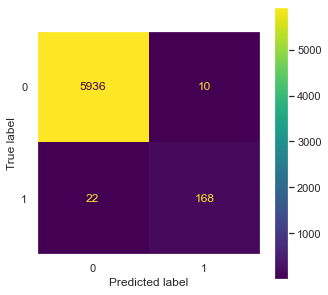

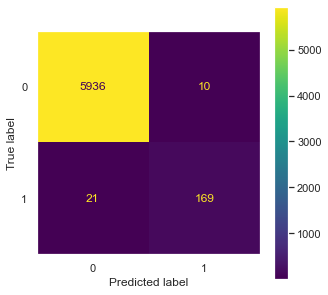

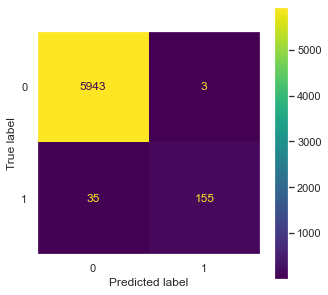

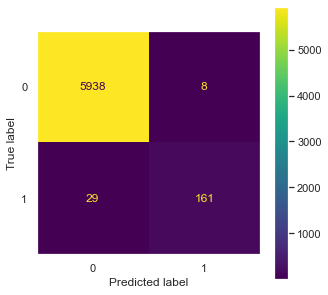

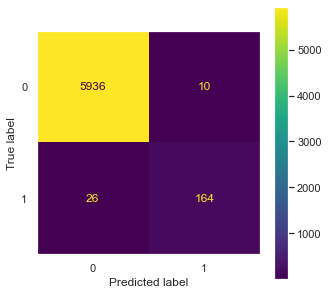

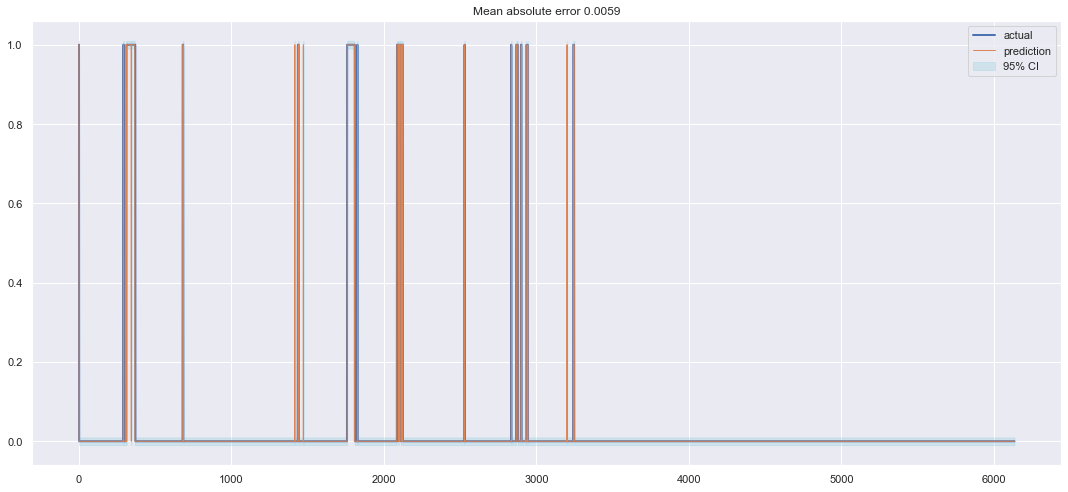

In [243]:

BigSnow = df.copy()
BigSnow['Sniezyca'] = 0
BigSnow.loc[BigSnow['Wysokosc pokrywy snieznej [cm]'] >= 15,'Sniezyca'] = 1
x, y = Rolling_window(BigSnow,('Wysokosc pokrywy snieznej [cm]',
    'Srednia temperatura dobowa [oC]'),'Sniezyca',3)
model = plot_model_results(x, y, plot_intervals=True)

In [88]:
#Snow- korelacja
import math
print("Temp - Wysokosc pokrywy snieznej")
Analysis.Korelacja(Snow['Srednia temperatura dobowa [oC]'], K2 = Pokrywa_s)
print("\nwilgotność - wysokość pokrywy śnieżnej")
Analysis.Korelacja(K1=Snow['Srednia dobowa wilgotnosc wzgledna [%]'], K2 = Pokrywa_s)
print("Temp - Wysokosc pokrywy snieznej - cały zbiór")
Analysis.Korelacja(df['Srednia temperatura dobowa [oC]'], K2 = df['Suma dobowa opadu [mm]'])
print("\nwilgotność - wysokość pokrywy śnieżnej - cały zbiór")
Analysis.Korelacja(K1=df['Srednia dobowa wilgotnosc wzgledna [%]'], K2 = df['Suma dobowa opadu [mm]'])

Temp - Wysokosc pokrywy snieznej
Korelacja Pearsona: -0.08257989663215994; p = 0.6172247448140242
Korelacja Spearmana: -0.19744467723698028; p = 0.2282695889514062
R^2: -0.08257989663215992 Std_err:0.5296512534291687

wilgotność - wysokość pokrywy śnieżnej
Korelacja Pearsona: -0.29544521428018644; p = 0.06784603056846893
Korelacja Spearmana: -0.3575705865113469; p = 0.025427932565651432
R^2: -0.2954452142801864 Std_err:0.31359427227600134
Temp - Wysokosc pokrywy snieznej - cały zbiór
Korelacja Pearsona: 0.11789961067991156; p = 3.2199764499786075e-64
Korelacja Spearmana: -0.029209895816951652; p = 2.9387447934115792e-05
R^2: 0.11789961067990977 Std_err:0.0030715420109014495

wilgotność - wysokość pokrywy śnieżnej - cały zbiór
Korelacja Pearsona: 0.20629060785631886; p = 1.985697192479404e-195
Korelacja Spearmana: 0.3774831710698089; p = 0.0
R^2: 0.20629060785631573 Std_err:0.0021215012395004373


In [89]:
#Wczytanie plików .csv pandasem - Wichura
#df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])

Wichura = df.copy()
Wichura['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Wichura.size / Wichura.columns.size)):
    Temp[x] = Wichura.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Wichura.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Wichura['dP'] = Temp

#df[]
Wichura = Wichura.loc[(Wichura['Czas trwania wiatru >15m/s [godziny]'] != 0) & (Wichura['Status pomiaru FF15'] != '8')]
Wichura = Wichura.loc[(Wichura['Status pomiaru PPPS'] != '8')]
Wichura = Wichura.loc[(Wichura['Status pomiaru STD'] != '8')]

c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Robin\AppData\Local\Temp\ipykernel_28844\1963273815.py:89: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([p1,p2,p3], labels=Legenda)


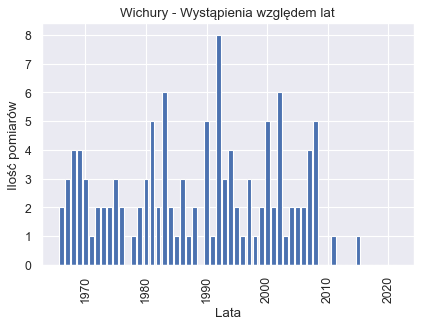

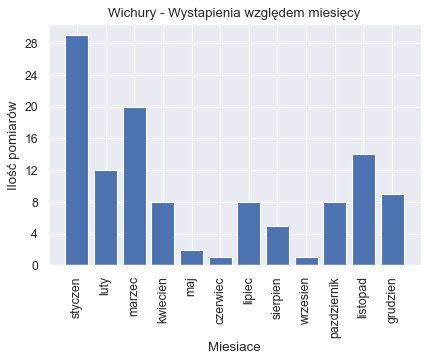

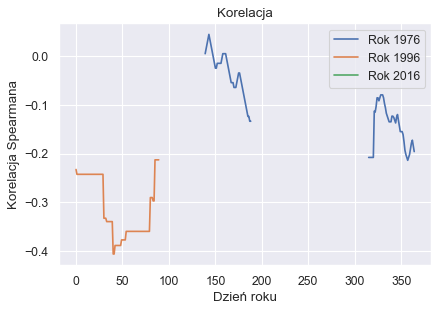

C:\Users\Robin\AppData\Local\Temp\ipykernel_28844\1963273815.py:115: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([p1,p2,p3,p4,p5], labels=Legenda)


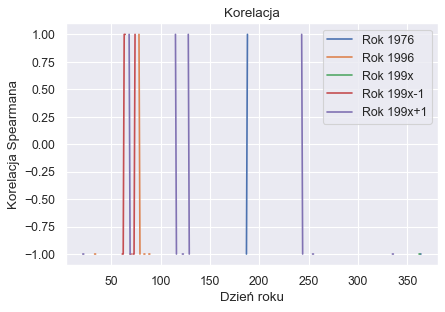

In [181]:
#Wichura
Czas_w = Wichura['Czas trwania wiatru >15m/s [godziny]']
Cisnienie_w = Wichura['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Srednia_temp_w = Wichura['Srednia temperatura dobowa [oC]']
Kolor_w = Wichura['Srednia dobowa predkosc wiatru [m/s]']
Wystapienie_wichury = Wichura['Rok']
temp1 = Wichura[['Czas trwania wiatru >15m/s [godziny]','Srednie dobowe cisnienie na poziomie stacji [hPa]','Srednia temperatura dobowa [oC]','Srednia dobowa predkosc wiatru [m/s]']]
temp1.columns = ['Wiatr >15m/s [h]', 'Śr ciśnienie atm [hPa]','Śr temp. [oC]','Śr v wiatru [m/s]']

# fig = px.scatter_3d(temp1, x= 'Śr ciśnienie atm [hPa]',
#                         z= 'Wiatr >15m/s [h]', 
#                         y= 'Śr temp. [oC]', color= 'Śr v wiatru [m/s]')
# fig.show()

# fig, ax = plt.subplots()
# Cisnienie_w.hist(bins = 20)#, by = 'Miesiac')
# ax.set_title('Histogram - Ciśnienie')
# ax.set_xlabel('Ciśnienie [hPa]')
# ax.set_ylabel('Ilość pomiarów')

# fig, ax = plt.subplots()
# Wichura['dP'].hist(bins = 50)#, by = 'Miesiac')
# ax.set_title('Histogram - dP')
# ax.set_xlabel('Ciśnienie [hPa]')
# ax.set_ylabel('Ilość pomiarów')

# fig, ax = plt.subplots()
# Srednia_temp_w.hist(bins = 20)#, by = 'Miesiac')
# ax.set_title('Histogram - Temperatura')
# ax.set_xlabel('Średnia temp. [C]')
# ax.set_ylabel('Ilość pomiarów')

# fig, ax = plt.subplots()
# Czas_w.hist(bins = 50)
# ax.set_title('Histogram - Czas trwania wiatru >15m/s')
# ax.set_xlabel('Czas trwania wiatru >15m/s [h]')
# ax.set_ylabel('Ilość pomiarów')

# fig, ax = plt.subplots()
# Kolor_w.hist(bins = 50)
# ax.set_title('Histogram - Średnia prędkość wiatru')
# ax.set_xlabel('Średnia prędkość wiatru [m/s]')
# ax.set_ylabel('Ilość pomiarów')


Wystapienia = Ilosc_Wystapien_lata(Wichura,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Wichura,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Wichury - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Wichury - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

#Generowanie na jednym wykresie, zakomentować opcje wykreślania w funkcji
fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Dzień roku')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)

data1 = df['Czas trwania wiatru >15m/s [godziny]']
data2 = df['Srednie dobowe cisnienie na poziomie stacji [hPa]']

#for n in range(2,3):
#    Korelacja_okno(data1,data2,30,n*365,(n-1)*365)
p1 = Korelacja_okno(data1,data2,50,9*365,(9-1)*365)
p2 = Korelacja_okno(data1,data2,50,29*365,(29-1)*365)
p3 = Korelacja_okno(data1,data2,50,49*365,(49-1)*365)
Legenda = ['Rok 1976','Rok 1996','Rok 2016']
ax.legend([p1,p2,p3], labels=Legenda)
plt.show()

fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Dzień roku')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
data1 = df['Czas trwania wiatru >15m/s [godziny]']
data2 = df['dP']

#for n in range(2,3):
#    Korelacja_okno(data1,data2,30,n*365,(n-1)*365)
window = 2
p1 = Korelacja_okno(data1,data2,window,9*365,(9-1)*365)
p2 = Korelacja_okno(data1,data2,window,29*365,(29-1)*365)
p3 = Korelacja_okno(data1,data2,window,26*365,(26-1)*365)
p4 = Korelacja_okno(data1,data2,window,25*365,(25-1)*365)
p5 = Korelacja_okno(data1,data2,window,27*365,(27-1)*365)
# 66- pierwszy rok
# +10 76
# +20 86
# +26 92
Legenda = ['Rok 1976','Rok 1996','Rok 199x','Rok 199x-1','Rok 199x+1']
ax.legend([p1,p2,p3,p4,p5], labels=Legenda)
plt.show()


Extra
[[6101   20]
 [  15    0]]
Ada
[[6121    0]
 [  15    0]]
Extra_limied
[[6121    0]
 [  15    0]]
Random
[[6112    9]
 [  15    0]]
Bagging
[[6114    7]
 [  15    0]]


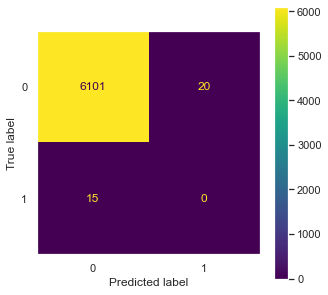

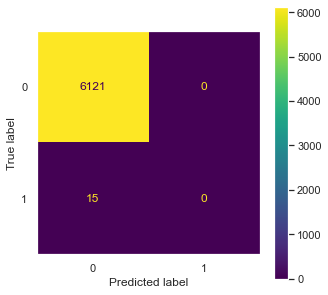

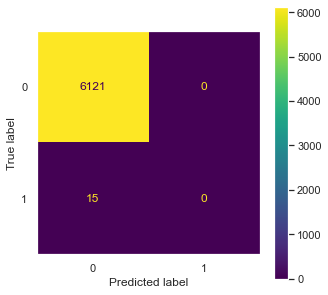

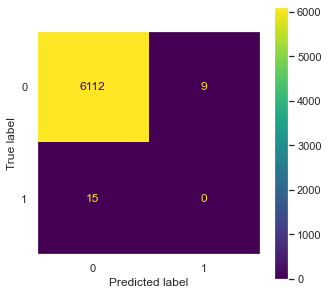

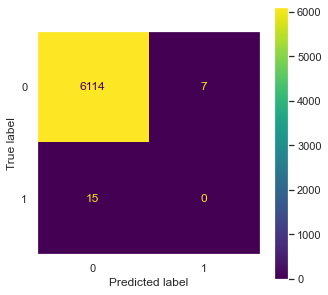

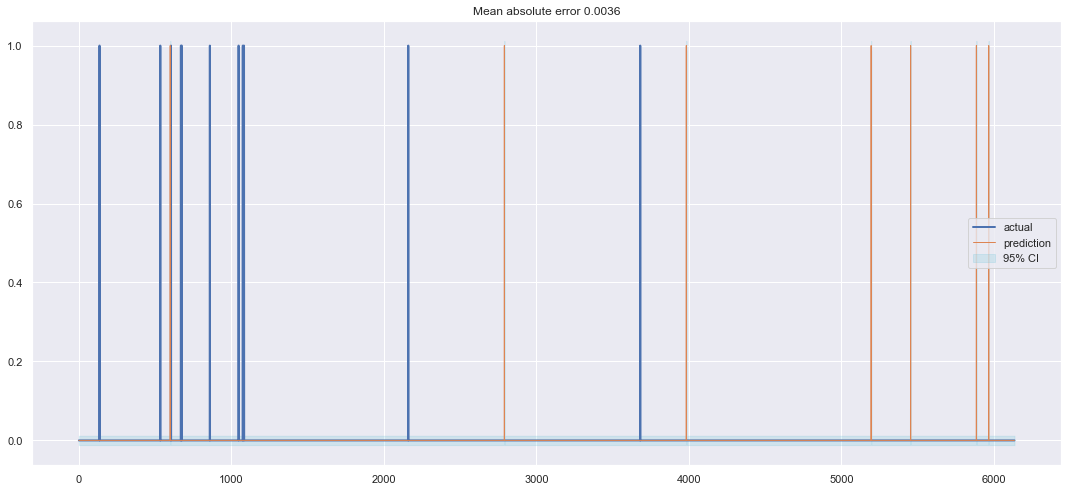

In [216]:
BigWind = df.copy()
BigWind['Wichura'] = 0
BigWind.loc[BigWind['Czas trwania wiatru >15m/s [godziny]'] != 0,'Wichura'] = 1
x, y = Rolling_window(BigWind,('Srednie dobowe cisnienie na poziomie stacji [hPa]',
    'Srednia temperatura dobowa [oC]'),'Wichura',2)
model = plot_model_results(x, y, plot_intervals=True)

In [91]:
#Wczytanie plików .csv pandasem - Burza
#df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])

Burza = df.copy()
Burza['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Burza.size / Burza.columns.size)):
    Temp[x] = Burza.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Burza.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Burza['dP'] = Temp
#df['']
Burza = Burza.loc[(Burza['Czas trwania burzy  [godziny]'] > 0) & (Burza['Status pomiaru BRZA'] != '8')]
Burza = Burza.loc[(Burza['Status pomiaru PPPS'] != '8')]
Burza = Burza.loc[(Burza['Status pomiaru STD'] != '8')]
Burza = Burza.loc[(Burza['Status pomiaru DZBL'] != '8')]

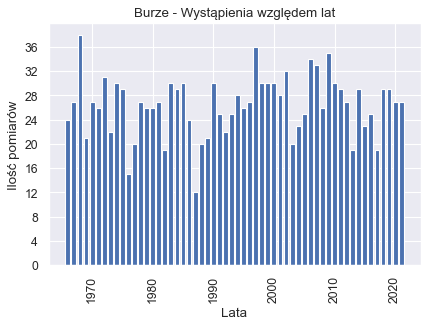

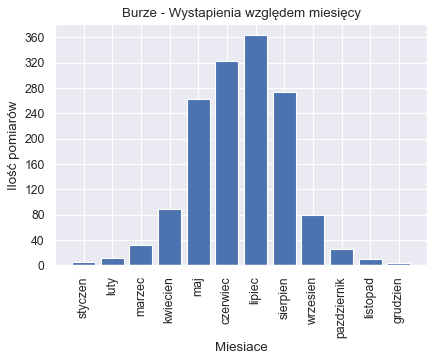

In [169]:
#Burza
Czas_b = Burza['Czas trwania burzy  [godziny]']
Cisnienie_b = Burza['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Srednia_temp_b = Burza['Srednia temperatura dobowa [oC]']
Wilgotnosc_b = Burza['Srednia dobowa wilgotnosc wzgledna [%]']
Sredni_wiatr_b = Burza['Srednia dobowa predkosc wiatru [m/s]']
Opady_b = Burza['Suma dobowa opadu [mm]']
Kolor_b = Burza['Wystapienie blyskawicy  [0/1]']

temp2 = Burza[['Czas trwania burzy  [godziny]','Srednie dobowe cisnienie na poziomie stacji [hPa]','Srednia temperatura dobowa [oC]','Srednia dobowa predkosc wiatru [m/s]', 'Srednia dobowa wilgotnosc wzgledna [%]','Suma dobowa opadu [mm]','Wystapienie blyskawicy  [0/1]']]
temp2.columns = ['Czas burzy [h]', 'Śr ciśnienie atm [hPa]','Śr temp. [oC]','Śr v wiatru [m/s]','Wilgotność [%]','Opady [mm]','Błyskawica [tak/nie]']

Wystapienie_burzy = Burza['Rok']

# fig, ax = plt.subplots()
# Wystapienie_burzy.hist(bins = 56)
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Lata')
# ax.set_ylabel('Ilość pomiarów')

Wystapienie_burzy_m = Burza['Miesiac']

counts = Wystapienie_burzy_m.nunique()

Wystapienia = Ilosc_Wystapien_lata(Burza,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Burza,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Burze - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Burze - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
data1 = df['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = df['Suma dobowa opadu [mm]']
# fig, ax = plt.subplots()
# Wystapienie_burzy_m.hist(bins = counts)#, by = 'Rok')
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Miesiac')
# ax.set_ylabel('Ilość pomiarów')


Extra
[[5454  216]
 [ 408   58]]
Ada
[[5667    3]
 [ 460    6]]
Extra_limied
[[5670    0]
 [ 466    0]]
Random
[[5489  181]
 [ 416   50]]
Bagging
[[5463  207]
 [ 409   57]]


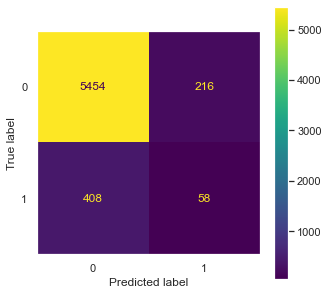

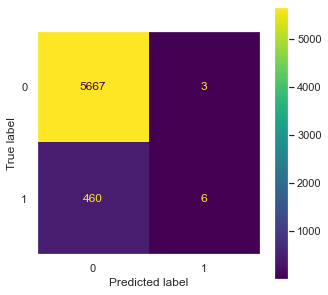

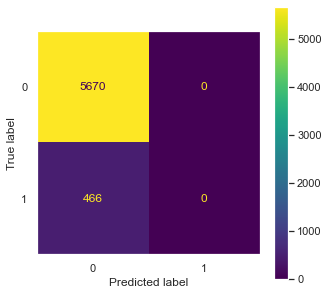

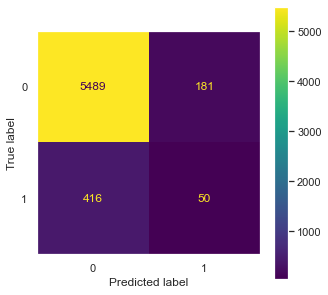

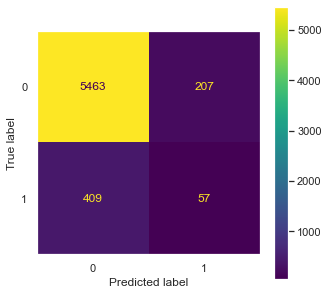

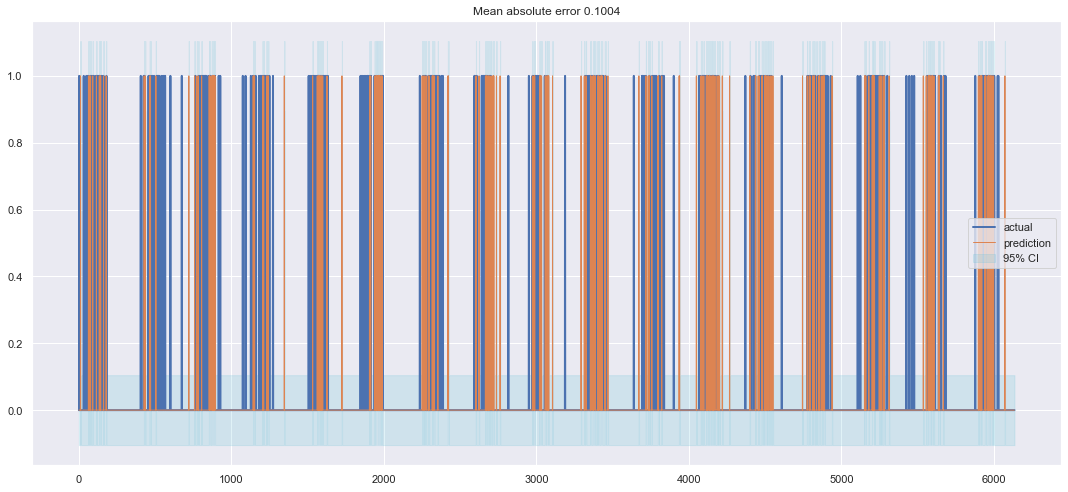

In [229]:
BigBurza = df.copy()
BigBurza['Burza'] = 0
df['Srednia dobowa wilgotnosc wzgledna [%]']
BigBurza.loc[(BigBurza['Czas trwania burzy  [godziny]'] > 0,'Burza')] = 1
x, y = Rolling_window(BigBurza,('Srednia temperatura dobowa [oC]',
    'Srednia dobowa wilgotnosc wzgledna [%]'),'Burza',2)
model = plot_model_results(x, y, plot_intervals=True)

c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
c:\Users\Robin\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


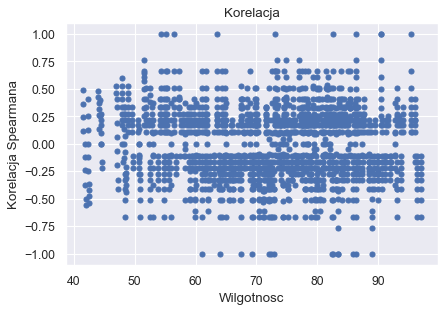

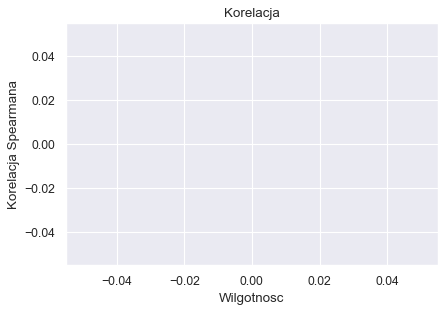

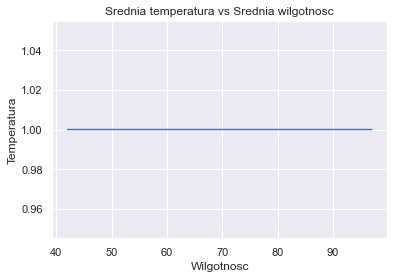

In [171]:
SortedBurza = df.copy().sort_values('Srednia dobowa wilgotnosc wzgledna [%]')
SortedBurzaUl = Burza.copy().sort_values('Srednia dobowa wilgotnosc wzgledna [%]')
#print(SortedWilgotnosc['Srednia dobowa wilgotnosc wzgledna [%]'].tail())
#print(SortedWilgotnoscUl['Srednia dobowa wilgotnosc wzgledna [%]'].tail())

fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
temp=SortedBurza.loc[(SortedBurza['Srednia dobowa wilgotnosc wzgledna [%]']>0 ) & (SortedBurza['Srednia dobowa wilgotnosc wzgledna [%]']<100 )]
data1 = temp['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = temp['Wystapienie burzy_']
p1 = Korelacja_okno_wilg(data1,data2,10,0,0)
plt.show()

fig, ax = plt.subplots()
ax.set_title('Korelacja')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Korelacja Spearmana')
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
data1 = SortedBurzaUl['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = SortedBurzaUl['Wystapienie burzy_']
p1 = Korelacja_okno_wilg(data1,data2,20,0,0)
plt.show()
fig, ax = plt.subplots()
ax.set_title('Srednia temperatura vs Srednia wilgotnosc')
ax.set_xlabel('Wilgotnosc')
ax.set_ylabel('Temperatura')

plt.plot(data1,data2)
plt.show()

In [ ]:
#Wczytanie plików .csv pandasem - Heat
#df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])

Heat = df.copy()
Heat['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Heat.size / Heat.columns.size)):
    Temp[x] = Heat.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Heat.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Heat['dP'] = Temp
#df['']
Heat = Heat.loc[(Heat['Status pomiaru TMAX'] != '8') & (Heat['Status pomiaru FWS'] != '8') & (Heat['Status pomiaru TMIN'] != '8')]
Heat = Heat.loc[(Heat['Status pomiaru PPPS'] != '8') & (Heat['Status pomiaru NOS'] != '8')]
Heat = Heat.loc[(Heat['Maksymalna temperatura dobowa [oC]'] >= 30) & (Heat['Minimalna temperatura dobowa [oC]'] >= 15)]

In [ ]:
#Heat
Cisnienie_h = Heat['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Sredni_wiatr_h = Heat['Srednia dobowa predkosc wiatru [m/s]']
Max_temp_h = Heat['Maksymalna temperatura dobowa [oC]']
Kolor_h = Heat['Srednie dobowe zachmurzenie ogolne [oktanty]']
Wystapienie_h = Heat['Rok']

temp3 = Heat[['Srednie dobowe cisnienie na poziomie stacji [hPa]','Srednia dobowa predkosc wiatru [m/s]','Maksymalna temperatura dobowa [oC]','Srednie dobowe zachmurzenie ogolne [oktanty]']]
temp3.columns = ['Śr. ciśnienie atm [hPa]','Śr. v wiatru [m/s]','Max temp. [oC]','Śr. zachmurzenie [oktanty]']


In [ ]:
#Heat - wykresy
# fig, ax = plt.subplots()
# Wystapienie_h.hist(bins = 56)#, by = 'Rok')
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Lata')
# ax.set_ylabel('Ilość pomiarów')

# Wystapienie_h_h = Heat['Miesiac']
# counts = Wystapienie_h_h.nunique()
# fig, ax = plt.subplots()
# Wystapienie_h_h.hist(bins = 12)#, by = 'Rok')
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Miesiac')
# ax.set_ylabel('Ilość pomiarów')


Wystapienia = Ilosc_Wystapien_lata(Heat,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Heat,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Upał - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))


fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Upał - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
data1 = df['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = df['Suma dobowa opadu [mm]']


Extra
[[5948   13]
 [ 137   38]]
Precision:  [0.97748562 0.74509804] Recall:  [0.99781916 0.21714286] Support:  [5961  175]
Ada
[[5923   38]
 [ 119   56]]
Precision:  [0.98030453 0.59574468] Recall:  [0.99362523 0.32      ] Support:  [5961  175]
Extra_limied
[[5961    0]
 [ 167    8]]
Precision:  [0.97274804 1.        ] Recall:  [1.         0.04571429] Support:  [5961  175]
Random
[[5930   31]
 [ 125   50]]
Precision:  [0.9793559  0.61728395] Recall:  [0.99479953 0.28571429] Support:  [5961  175]
Bagging
[[5923   38]
 [ 129   46]]
Precision:  [0.97868473 0.54761905] Recall:  [0.99362523 0.26285714] Support:  [5961  175]


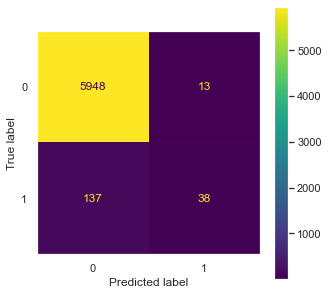

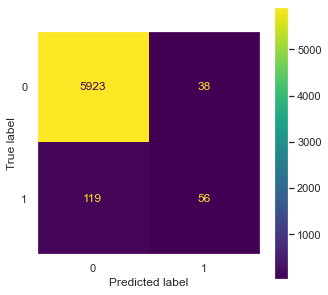

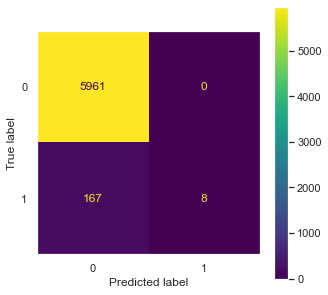

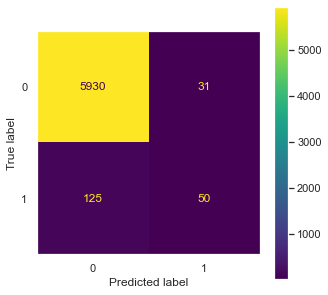

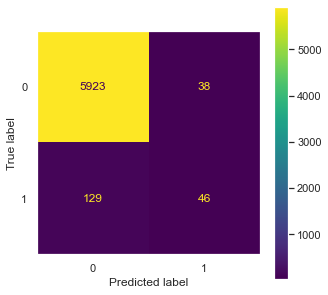

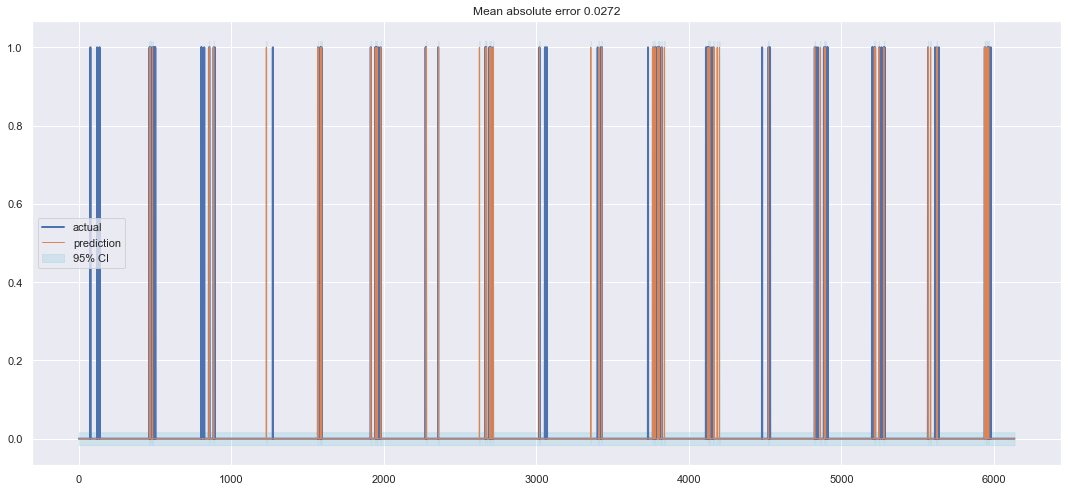

In [272]:
#Heat
BigHeat = df.copy()
BigHeat['Heat'] = 0
df['Pora roku']
df['Minimalna temperatura dobowa [oC]']
df['Srednia temperatura dobowa [oC]']
df['Srednie dobowe zachmurzenie ogolne [oktanty]']
df['Srednie dobowe cisnienie na poziomie stacji [hPa]']
df['Maksymalna temperatura dobowa [oC]']
df['Minimalna temperatura dobowa [oC]']
BigHeat.loc[(BigHeat['Maksymalna temperatura dobowa [oC]'] >= 30) & (BigHeat['Minimalna temperatura dobowa [oC]'] >= 15),'Heat'] = 1
x, y = Rolling_window(BigHeat,('Srednie dobowe zachmurzenie ogolne [oktanty]',
    'Maksymalna temperatura dobowa [oC]','Srednia temperatura dobowa [oC]'),'Heat',4)
model = plot_model_results(x, y, plot_intervals=True)

In [ ]:
#Wczytanie plików .csv pandasem - Cold
#df = pd.read_csv(filepath_or_buffer = path_s_d, delimiter = ";", encoding='cp1250', low_memory=False)#, index_col=[0])

Cold = df.copy()
Cold['Kolor'] = np.zeros(20454)

Temp = np.zeros(20454)
w0=0
m0=0
for x in range(1,(int)(Cold.size / Cold.columns.size)):
    Temp[x] = Cold.iloc[x]['Srednie dobowe cisnienie na poziomie stacji [hPa]'] - Cold.iloc[x-1]['Srednie dobowe cisnienie na poziomie stacji [hPa]']

Cold['dP'] = Temp
#df['']
Cold = Cold.loc[(Cold['Status pomiaru TMAX'] != '8') & (Cold['Status pomiaru FWS'] != '8') & (Cold['Status pomiaru TMIN'] != '8')]
Cold = Cold.loc[(Cold['Status pomiaru PPPS'] != '8') & (Cold['Status pomiaru NOS'] != '8')]
Cold = Cold.loc[(Cold['Maksymalna temperatura dobowa [oC]'] <= -5) & (Cold['Minimalna temperatura dobowa [oC]'] <= -15)]

In [ ]:
#Cold
Cisnienie_c = Cold['Srednie dobowe cisnienie na poziomie stacji [hPa]']
Sredni_wiatr_c = Cold['Srednia dobowa predkosc wiatru [m/s]']
Min_temp_c = Cold['Minimalna temperatura dobowa [oC]']
Kolor_c = Cold['Srednie dobowe zachmurzenie ogolne [oktanty]']
Wystapienie_c = Cold['Rok']
temp4 = Cold[['Srednie dobowe cisnienie na poziomie stacji [hPa]','Srednia dobowa predkosc wiatru [m/s]','Minimalna temperatura dobowa [oC]','Srednie dobowe zachmurzenie ogolne [oktanty]']]
temp4.columns = ['Śr. ciśnienie atm [hPa]','Śr. v wiatru [m/s]','Min temp. [oC]','Śr. zachmurzenie [oktanty]']

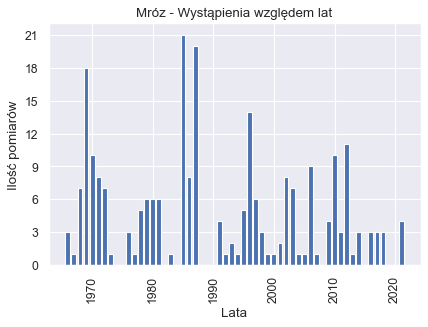

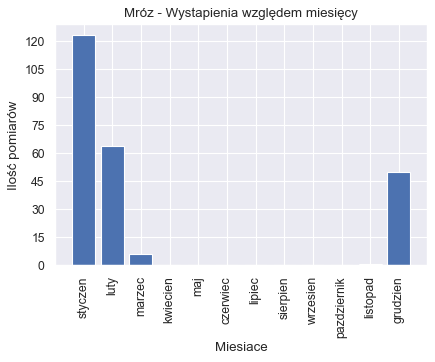

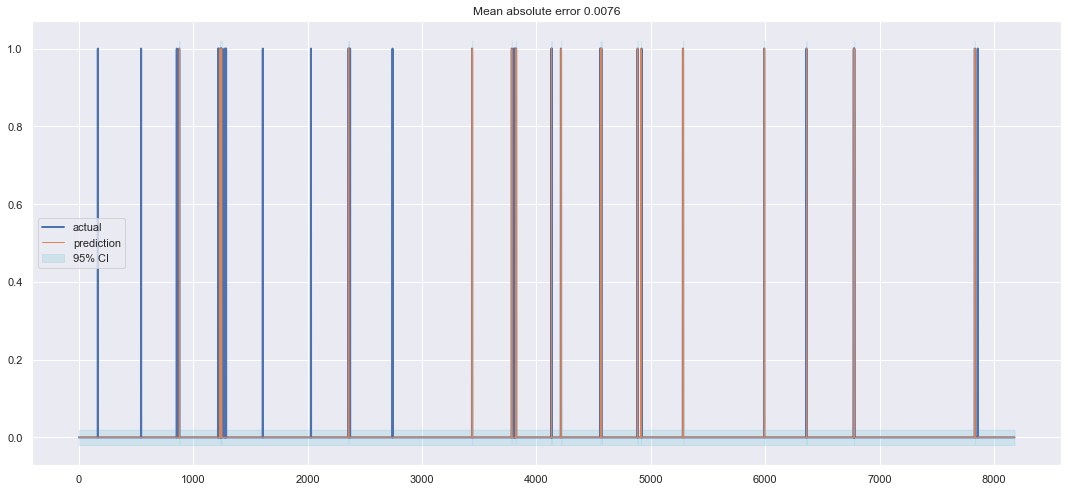

In [103]:
#Cold - Wykresy
# fig, ax = plt.subplots()
# Wystapienie_c.hist(bins = 56)#, by = 'Rok')
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Lata')
# ax.set_ylabel('Ilość pomiarów')

# Wystapienie_c_c = Cold['Miesiac']
# counts = Wystapienie_c_c.nunique()

# fig, ax = plt.subplots()
# plt.bar(Wystapienie_c_c,counts)
# Wystapienie_c_c.hist(bins = 12)#, by = 'Rok')
# ax.set_title('Histogram - Wystapienia')
# ax.set_xlabel('Lata')
# ax.set_ylabel('Ilość pomiarów')


Wystapienia = Ilosc_Wystapien_lata(Cold,Lata)
Wystapienia_m = Ilosc_Wystapien_miesiace(Cold,Miesiace)

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Wystapienia['Rok'],Wystapienia['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Mróz - Wystąpienia względem lat')
ax.set_xlabel('Lata')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig, ax = plt.subplots()
fig.dpi = 80 #dpi = 72 H=4, W=6
fig.set_figheight(4)
fig.set_figwidth(6)
plt.bar(Miesiace_names, Wystapienia_m['Ilosc'])
plt.xticks(rotation=90)
ax.set_title('Mróz - Wystapienia względem miesięcy')
ax.set_xlabel('Miesiace')
ax.set_ylabel('Ilość pomiarów')
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
data1 = df['Srednia dobowa wilgotnosc wzgledna [%]']
data2 = df['Suma dobowa opadu [mm]']


Extra
[[6073    7]
 [  36   19]]
Precision:  [0.99410706 0.73076923] Recall:  [0.99884868 0.34545455] Support:  [6080   55]
Ada
[[6070   10]
 [  28   27]]
Precision:  [0.99540833 0.72972973] Recall:  [0.99835526 0.49090909] Support:  [6080   55]
Extra_limied
[[6079    1]
 [  47    8]]
Precision:  [0.99232778 0.88888889] Recall:  [0.99983553 0.14545455] Support:  [6080   55]
Random
[[6071    9]
 [  35   20]]
Precision:  [0.99426793 0.68965517] Recall:  [0.99851974 0.36363636] Support:  [6080   55]
Bagging
[[6063   17]
 [  34   21]]
Precision:  [0.99442349 0.55263158] Recall:  [0.99720395 0.38181818] Support:  [6080   55]


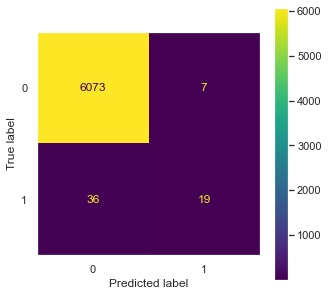

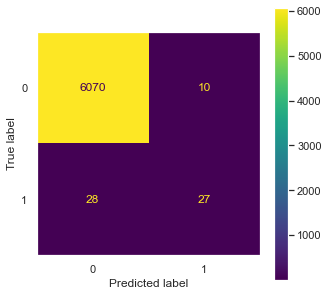

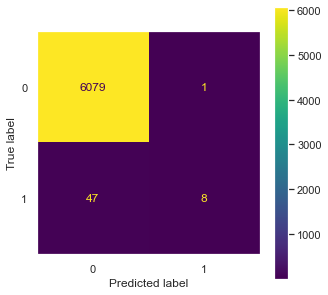

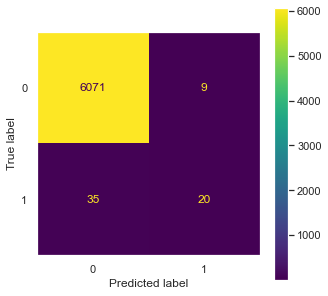

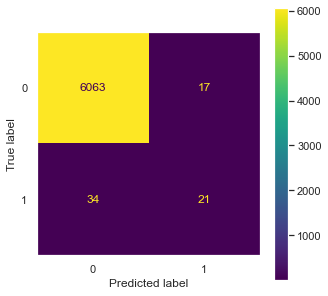

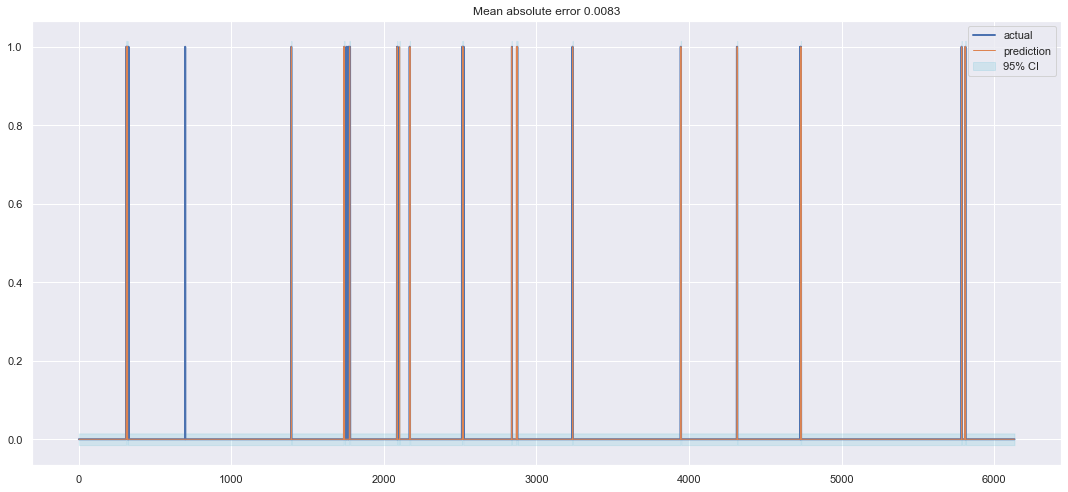

In [303]:
BigCold = df.copy()
BigCold['Cold'] = 0
df['Minimalna temperatura dobowa [oC]']
df['Srednia temperatura dobowa [oC]']
df['Srednie dobowe zachmurzenie ogolne [oktanty]']
df['Srednie dobowe cisnienie na poziomie stacji [hPa]']
BigCold.loc[(BigCold['Maksymalna temperatura dobowa [oC]'] <= -5) & (BigCold['Minimalna temperatura dobowa [oC]'] <= -15),'Cold'] = 1
x, y = Rolling_window(BigCold,('Maksymalna temperatura dobowa [oC]',
    'Srednia temperatura dobowa [oC]','Minimalna temperatura dobowa [oC]'),'Cold',7)
model = plot_model_results(x, y, plot_intervals=True)

In [ ]:
# Cor_Temp2 = Ulewa[['Suma dobowa opadu [mm]','Srednie dobowe cisnienie na poziomie stacji [hPa]','Srednia temperatura dobowa [oC]']].copy()
# Cor_Temp = Cor_Temp2.corr()

# x = 'Srednie dobowe cisnienie na poziomie stacji [hPa]'
# y = 'Srednia temperatura dobowa [oC]'
# z = 'Suma dobowa opadu [mm]'

# # Pairings
# xz = Cor_Temp.loc[ x, z ]
# yz = Cor_Temp.loc[ y, z ]
# xy = Cor_Temp.loc[ x, y ]

# Rxyz = math.sqrt((abs(xz**2) + abs(yz**2) - 2*xz*yz*xy) / (1-abs(xy**2)) )
# R2 = Rxyz**2

# # Calculate adjusted R-squared
# n = len(Cor_Temp2) # Number of rows
# k = 2       # Number of independent variables
# R2_adj = 1 - ( ((1-R2)*(n-1)) / (n-k-1) )
# print('R2 = '+str(R2) +' R2_adj = ' + str(R2_adj))

In [ ]:
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from sklearn.manifold import Isomap
# from sklearn.linear_model import LogisticRegression

# # define dataset
# steps = [('iso', Isomap(n_components=2)), ('m', LogisticRegression())]
# model = Pipeline(steps=steps)
# # evaluate model
# tempnp = np.array([Cisnienie,Srednia_temp])
# tempnp2 = np.array(Opady)
# tempnp=np.moveaxis(tempnp,-1,0)
# print(tempnp.shape)
# print(tempnp)
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, tempnp, tempnp2, scoring='accuracy', cv=cv, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# # evaluate isomap with logistic regression algorithm for classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.pipeline import Pipeline
# from sklearn.manifold import Isomap
# from sklearn.linear_model import LogisticRegression
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=10, random_state=7)
# print(X.size)
# print(X.shape)
# print(X)
# print(y.size)
# print(y.shape)
# print(y)
# # define the pipeline
# steps = [('iso', Isomap(n_components=10)), ('m', LogisticRegression())]
# model = Pipeline(steps=steps)
# # evaluate model
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Opis tekstowy
1. Ciśnienie -> Opady

test_log = ['Srednia dobowe cisnienie na poziomie stacji [hpa]'] > 0
test_log = ['Status pomiaru SMDB [hpa]'] != 8

dob_sr_cs = df['Srednia dobowe cisnienie na poziomie stacji [hpa]']
dob_sum_op = df['Suma dobowa opadu [mm]']

dob_sr_cs 

['Srednia dobowe cisnienie na poziomie stacji [hpa]'] -> ['Suma dobowa opadu [mm]']


X = df['column'].var()
df['column_name'].std()
df['column1'].median()
df.mode()

!# Korelacja spearmana
coef, p = scipy.stats.spearmanr(data1, data2)
!# Korelacja kandela
coef, p = scipy.stats.kendalltau(data1, data2)

Wykresy: (punktowy, liniowy, etc., heatmapa)